
Downloading the dataset

We will be using the dataset from kaggle https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

In [3]:
dataset_url = "https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia"

In [4]:
od.download(dataset_url)

  1%|          | 20.0M/2.29G [00:00<00:11, 204MB/s]

100%|██████████| 2.29G/2.29G [00:34<00:00, 72.2MB/s]


In [5]:
data_dir = "./chest-xray-pneumonia/chest_xray"

In [6]:
import shutil

shutil.rmtree(data_dir + "/__MACOSX")
shutil.rmtree(data_dir + "/chest_xray")

In [7]:
import os

In [8]:
os.listdir(data_dir)

['train', 'val', 'test']

Deleting unecessary folders

In [9]:
os.listdir(data_dir)

['train', 'val', 'test']

Import the dataset <br>
Use the ImageFolder class from torchvision

In [10]:
from torchvision.datasets import ImageFolder

In [11]:
dataset = ImageFolder(data_dir)

In [12]:
len(dataset)

5856

In [13]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=1857x1317 at 0x7F417D5D1FD0>, 0)

In [14]:
dataset.classes

['test', 'train', 'val']

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

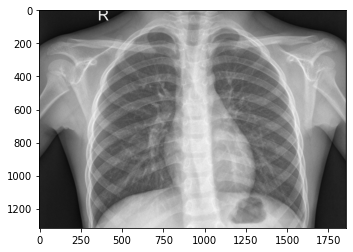

In [16]:
img, label = dataset[0]
plt.imshow(img)

In [17]:
import torchvision.transforms as tt
# dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(64), tt.CenterCrop(64), tt.ToTensor()]))

In [18]:
# img, label = [0]

# plt.imshow(img.permute((1,2,0)))

In [19]:
train_ds = ImageFolder(data_dir + "/train",tt.Compose([tt.Resize(224), tt.CenterCrop(224), tt.ToTensor()]))
test_ds = ImageFolder(data_dir + "/test",tt.Compose([tt.Resize(224), tt.CenterCrop(224), tt.ToTensor()]))
val_ds = ImageFolder(data_dir + "/val",tt.Compose([tt.Resize(224), tt.CenterCrop(224), tt.ToTensor()]))

Checking the length of each set

In [20]:
len(train_ds)

5216

In [21]:
len(test_ds)

624

In [22]:
len(train_ds)

5216

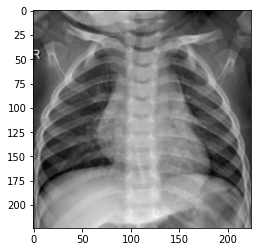

In [23]:
img, label = train_ds[1]

plt.imshow(img.permute((1,2,0)))

creating data loader

In [24]:
from torch.utils.data import DataLoader
batch_size = 10

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)
val_dl = DataLoader(val_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


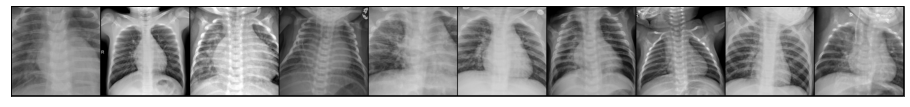

In [26]:
show_batch(train_dl)

To check the no. of images in each class

In [27]:
for cls in os.listdir(data_dir):
    PNEUMONIA_LEN = len(os.listdir(data_dir + "/" + cls + "/" + "PNEUMONIA"))
    NORMAL_LEN = len(os.listdir(data_dir + "/" + cls + "/" + "NORMAL"))
    print(cls, ":", PNEUMONIA_LEN)
    print(cls, ":", NORMAL_LEN)
    print("total",cls,":", PNEUMONIA_LEN + NORMAL_LEN)



train : 3875
train : 1341
total train : 5216
val : 8
val : 8
total val : 16
test : 390
test : 234
total test : 624


Utility Functions and Classes

GPU Utilities

In [28]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
torch.cuda.is_available()

True

In [30]:
device = get_default_device()

In [31]:
device

device(type='cuda')

0


torch.Size([3, 224, 224])

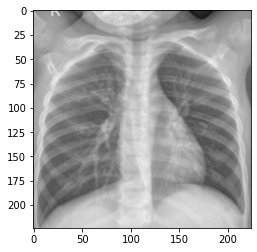

In [32]:
# just checking
img, label = test_ds[5]
plt.imshow(img.permute((1,2,0)))
print(label)
img.shape

In [33]:
img.device

device(type='cpu')

In [34]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [35]:

train_dl = DeviceDataLoader(train_dl, device )
val_dl = DeviceDataLoader(val_dl, device)
print(train_dl.device, val_dl.device)

cuda cuda


Model and Training Utilities

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    "Evaluate the models performance on the validation set"
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model (ResNet9)

In [38]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 10 x x 3 x 224 x 224
        self.conv1 = conv_block(in_channels, 224) #Input: 10 x 224 x 224 x 224
        self.conv2 = conv_block(224, 128, pool=True) #Input: 10 x 128 x 112 x 112, feature map is reduced to 16 x 16 because pool is set to true
        self.res1 = nn.Sequential(conv_block(128, 128), #Input: 10 x  128 x 112 x 112
                                  conv_block(128, 128)) # 10 x 128 x 112 x 112
        
        self.conv3 = conv_block(128, 256, pool=True) # 10 x 256 x 28 x 28
        self.conv4 = conv_block(256, 512, pool=True) # 10 x 512 x 14 x 14
        self.res2 = nn.Sequential(conv_block(512, 512), # 10 x 512 x 14 x 14
                                  conv_block(512, 512)) # 10 x 512 x 14 x 14
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 10 x 512 x 1 x 1
                                        nn.Flatten(), # 10 x 512
                                        nn.Dropout(0.2), # . Dropout makes the model learn by analyzing relationships not by specific values
                                        nn.Linear(512, num_classes))   
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [39]:
model = to_device(ResNet9(3, len(train_ds.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(224, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [40]:
# Checking if the weight of a layer is on cude
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [41]:
for batch in train_dl:
  images, label = batch
  print("images.shape",images.shape)
  print("images.device",images.device)
  preds = model(images)
  print("preds.shape", preds.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([10, 3, 224, 224])
images.device cuda:0
preds.shape torch.Size([10, 2])


Traing the Model

In [42]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.6000000238418579, 'val_loss': 0.68265700340271}]

In [44]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.1358, val_loss: 0.3997, val_acc: 0.7500
Epoch [1], train_loss: 0.1211, val_loss: 0.7504, val_acc: 0.6000
Epoch [2], train_loss: 0.1092, val_loss: 0.5724, val_acc: 0.6500
Epoch [3], train_loss: 0.1083, val_loss: 1.0070, val_acc: 0.6000
Epoch [4], train_loss: 0.0913, val_loss: 0.8690, val_acc: 0.6500


In [45]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0985, val_loss: 0.8365, val_acc: 0.6000
Epoch [1], train_loss: 0.0896, val_loss: 0.9225, val_acc: 0.6000
Epoch [2], train_loss: 0.0824, val_loss: 0.4263, val_acc: 0.8000
Epoch [3], train_loss: 0.0733, val_loss: 0.8464, val_acc: 0.6000
Epoch [4], train_loss: 0.0659, val_loss: 0.4405, val_acc: 0.7667


In [46]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0682, val_loss: 1.0862, val_acc: 0.6000
Epoch [1], train_loss: 0.0640, val_loss: 0.3747, val_acc: 0.8167
Epoch [2], train_loss: 0.0613, val_loss: 0.4133, val_acc: 0.8000
Epoch [3], train_loss: 0.0619, val_loss: 0.3595, val_acc: 0.8500
Epoch [4], train_loss: 0.0475, val_loss: 0.5359, val_acc: 0.7500


In [47]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0434, val_loss: 0.9015, val_acc: 0.7000
Epoch [1], train_loss: 0.0480, val_loss: 0.7840, val_acc: 0.7000
Epoch [2], train_loss: 0.0402, val_loss: 0.6593, val_acc: 0.8000
Epoch [3], train_loss: 0.0346, val_loss: 0.3622, val_acc: 0.8167
Epoch [4], train_loss: 0.0404, val_loss: 0.3407, val_acc: 0.8167


In [51]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0360, val_loss: 0.4599, val_acc: 0.8167
Epoch [1], train_loss: 0.0322, val_loss: 0.9011, val_acc: 0.8000
Epoch [2], train_loss: 0.0276, val_loss: 0.7614, val_acc: 0.8000
Epoch [3], train_loss: 0.0307, val_loss: 0.6026, val_acc: 0.7167
Epoch [4], train_loss: 0.0315, val_loss: 0.7703, val_acc: 0.7500


In [55]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0319, val_loss: 0.6800, val_acc: 0.7500
Epoch [1], train_loss: 0.0250, val_loss: 0.5885, val_acc: 0.8167
Epoch [2], train_loss: 0.0179, val_loss: 0.4491, val_acc: 0.8000
Epoch [3], train_loss: 0.0225, val_loss: 0.5163, val_acc: 0.7667
Epoch [4], train_loss: 0.0165, val_loss: 0.6048, val_acc: 0.8000


In [56]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

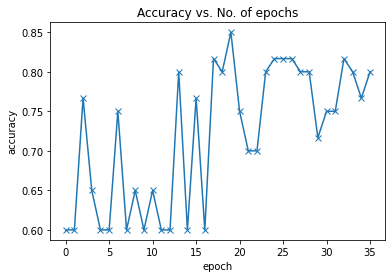

In [57]:
plot_accuracies(history)

In [62]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

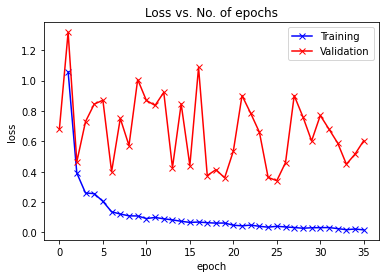

In [64]:
plot_losses(history)